In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from V_A_step_jump_fit_utils import PDF_hit_V_A_change, CDF_hit_V_A_change, rho_A_t_fn, cum_A_t_fn

import pickle

import random
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.integrate import trapezoid as trapz

# read data

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

T_trunc = 0.3
print('T_trunc:', T_trunc)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]
T_trunc: 0.3


# led on and off

In [3]:
df_led_off = df [ df['LED_trial'] == 0]
df_led_off_trunc_aborts = df_led_off[ (df_led_off['timed_fix'] < df_led_off['intended_fix']) & (df_led_off['timed_fix'] > T_trunc)]
led_off_trunc_aborts = df_led_off_trunc_aborts['timed_fix']
frac_aborts_off = len(led_off_trunc_aborts) / len(df_led_off)


df_led_on = df [ df['LED_trial'] == 1]
df_led_on_trunc_aborts = df_led_on[ (df_led_on['timed_fix'] < df_led_on['intended_fix']) & (df_led_on['timed_fix'] > T_trunc)]
led_on_trunc_aborts = df_led_on_trunc_aborts['timed_fix']
frac_aborts_on = len(led_on_trunc_aborts) / len(df_led_on)

print('frac_aborts_off:', frac_aborts_off)
print('frac_aborts_on:', frac_aborts_on)

frac_aborts_off: 0.12307854921027996
frac_aborts_on: 0.1515062454077884


# plot data

In [4]:
bw_data = 0.05
bins_data = np.arange(0, 2, bw_data)
t_pts_data = bins_data[:-1] + bw_data/2

off_hist, _ = np.histogram(led_off_trunc_aborts, bins=bins_data, density=True)
off_hist *= frac_aborts_off

on_hist, _ = np.histogram(led_on_trunc_aborts, bins=bins_data, density=True)
on_hist *= frac_aborts_on

Text(0.5, 1.0, 'data - trunc aborts ')

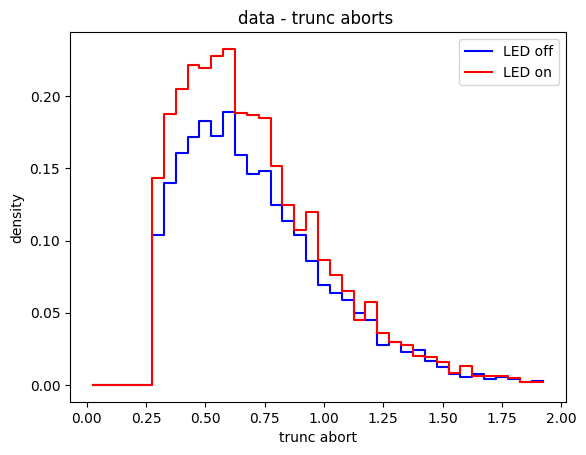

In [5]:
plt.step(t_pts_data, off_hist, label='LED off', color='b')
plt.step(t_pts_data, on_hist, label='LED on', color='r')

plt.xlabel('trunc abort')
plt.ylabel('density')
plt.legend()
plt.title('data - trunc aborts ')

# plt theory

In [6]:
bw_theory = 0.001
bins_theory = np.arange(0, 2, bw_theory)
t_pts_theory = bins_theory[:-1] + bw_theory/2

# LED off fn

In [7]:
def off_pdf_fn(t, t_stim, V_A, theta_A, t_A_aff, T_trunc, trunc_factor):
    """
    PDF(abort / t_stim) that is truncated after T_trunc
    """
    if t <= T_trunc or t >= t_stim:
        pdf = 0
    else:
        pdf = rho_A_t_fn(t - t_A_aff, V_A, theta_A) / trunc_factor

    return pdf


## Read from VBMC

In [8]:
with open('LED_OFF_VBMC_LT_RC_VP_DATA_0.pkl', 'rb') as f:
    vp_off = pickle.load(f)

vp_off_samples = vp_off.sample(int(1e6))[0]
V_A_off = np.mean(vp_off_samples[:, 0])
theta_A_off = np.mean(vp_off_samples[:, 1])
t_A_aff_off = np.mean(vp_off_samples[:, 2])

print(f'V_A_off: {V_A_off}, theta_A_off: {theta_A_off}, t_A_aff_off: {t_A_aff_off}')

V_A_off: 1.6137614731137147, theta_A_off: 2.573910959796514, t_A_aff_off: -0.1991788436335703


## sample for each t_stim

In [9]:
# M = 50000
# t_stim_sample = random.choices(t_stim_all, k=M)
# t_stim_all = df_led_off['intended_fix'].values

t_stim_sample = df_led_off['intended_fix'].values
M = len(t_stim_sample)

pdf_off_theory = np.zeros((M, len(t_pts_theory)))

trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_off, V_A_off, theta_A_off)
for i,t_stim in tqdm(enumerate(t_stim_sample), total=len(t_stim_sample)):
    pdf_off_theory[i, :] = [off_pdf_fn(t, t_stim, V_A_off, theta_A_off, t_A_aff_off, T_trunc, trunc_factor) for t in t_pts_theory]

100%|██████████| 66226/66226 [00:34<00:00, 1913.51it/s]


# LED on fn

In [10]:
def on_pdf_fn(t, base_V_A, new_V_A, theta_A, t_A_aff, t_led, trunc_factor, t_stim):   
    # pdf
    if t_led == 0:
        if t <= T_trunc or t >= t_stim:
            pdf = 0
        else:
            trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, new_V_A, theta_A)
            pdf = rho_A_t_fn(t - t_A_aff, new_V_A, theta_A) / trunc_factor
    else:
        if t <= T_trunc or t >= t_stim:
            pdf = 0
        else:
            pdf = PDF_hit_V_A_change(t - t_A_aff, base_V_A, new_V_A, theta_A, t_led) / trunc_factor
    
    if t > t_stim:
        pdf = 0

    return pdf

## read from vbmc

In [11]:
with open('V_A_step_jump_LED_on_vbmc.pkl', 'rb') as f:
    vp_on = pickle.load(f)

vp_on_samples = vp_on.sample(int(1e6))[0]

base_V_A_on = np.mean(vp_on_samples[:, 0])
new_V_A_on = np.mean(vp_on_samples[:, 1])
theta_A_on = np.mean(vp_on_samples[:, 2])
t_A_aff_on = np.mean(vp_on_samples[:, 3])

print(f'base_V_A_on: {base_V_A_on}, new_V_A_on: {new_V_A_on}, theta_A_on: {theta_A_on}, t_A_aff_on: {t_A_aff_on}')

base_V_A_on: 1.2783594922328156, new_V_A_on: 2.7456513136059533, theta_A_on: 1.873731172860882, t_A_aff_on: 0.02066769117770881


# sample for each t_led and t_stim

In [12]:
# M = 10000
# unique_pairs = list(zip(df_led_on['intended_fix'], df_led_on['intended_fix'] - df_led_on['LED_onset_time']))
# sampled_pairs = random.sample(unique_pairs, min(M, len(unique_pairs)))
sampled_pairs = list(zip(df_led_on['intended_fix'], df_led_on['intended_fix'] - df_led_on['LED_onset_time']))
M = len(sampled_pairs)

pdf_on_theory = np.zeros((M, len(t_pts_theory)))

def process_pair(i, t_stim, t_led):
    if t_stim <= t_led:
        print('Issue at index:', i)
        return i, None
    
    trunc_factor = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff_on, base_V_A_on, new_V_A_on, theta_A_on, t_led)
    pdf_on = np.array([on_pdf_fn(t, base_V_A_on, new_V_A_on, theta_A_on, t_A_aff_on, t_led, trunc_factor, t_stim) 
                        for t in t_pts_theory])
    return i, pdf_on

results = Parallel(n_jobs=30)(delayed(process_pair)(i, t_stim, t_led) for i, (t_stim, t_led) in tqdm(enumerate(sampled_pairs), total=len(sampled_pairs)))

for i, pdf_row in results:
    pdf_on_theory[i,:] = pdf_row

100%|██████████| 34025/34025 [02:42<00:00, 209.81it/s]


# Plot theory and data

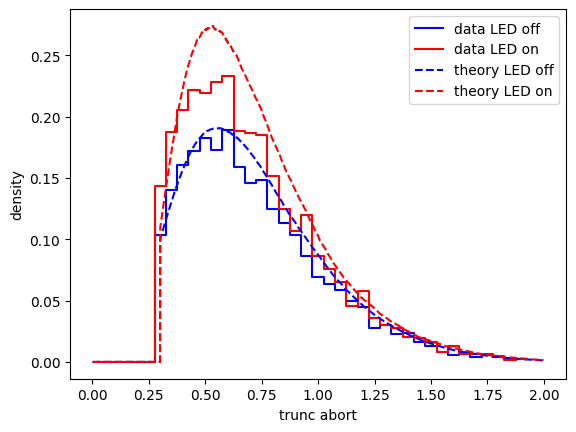

In [13]:
pdf_off_theory_mean = np.mean(pdf_off_theory, axis=0)
pdf_on_theory_mean = np.mean(pdf_on_theory, axis=0)

plt.step(t_pts_data, off_hist, label='data LED off', color='b')
plt.step(t_pts_data, on_hist, label='data LED on', color='r')

plt.plot(t_pts_theory, pdf_off_theory_mean, label='theory LED off', color='b', ls='--')
plt.plot(t_pts_theory, pdf_on_theory_mean, label='theory LED on', color='r', ls='--')
plt.legend()
plt.xlabel('trunc abort')
plt.ylabel('density');

(0.0, 0.3)

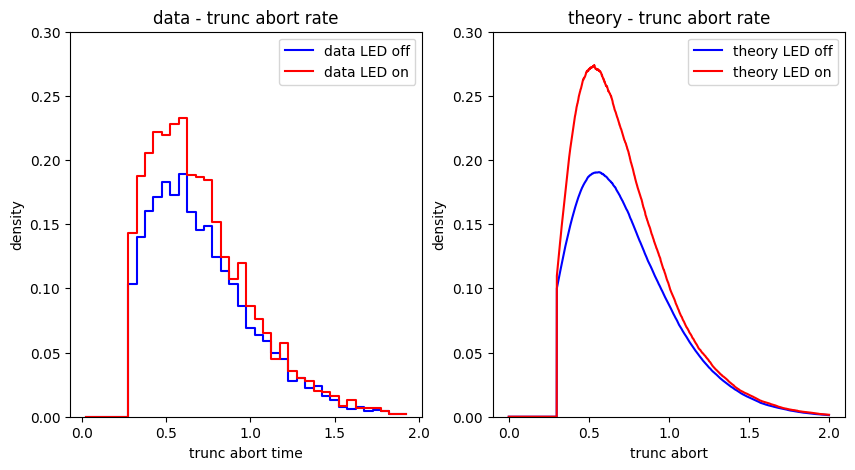

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.step(t_pts_data, off_hist, label='data LED off', color='b')
plt.step(t_pts_data, on_hist, label='data LED on', color='r')
plt.title('data - trunc abort rate')
plt.xlabel('trunc abort time'); plt.ylabel('density')
plt.legend()
plt.ylim(0, 0.3)

plt.subplot(1,2,2)
plt.plot(t_pts_theory, pdf_off_theory_mean, label='theory LED off', color='b')
plt.plot(t_pts_theory, pdf_on_theory_mean, label='theory LED on', color='r')
plt.legend()
plt.xlabel('trunc abort')
plt.ylabel('density');
plt.title('theory - trunc abort rate');
plt.ylim(0, 0.3)


# Align to LED onset 

In [16]:
bw_data_led = 0.03
bins_data_led = np.arange(-3, 3, bw_data_led)
t_pts_data_led = bins_data_led[:-1] + bw_data_led/2

bw_theory_led = 0.01
bins_theory_led = np.arange(-3, 3, bw_theory_led)
t_pts_theory_led = bins_theory_led[:-1] + bw_theory_led/2

## theory

In [19]:
# M = 25000
# unique_pairs = list(zip(df['intended_fix'], df['intended_fix'] - df['LED_onset_time']))
# sampled_pairs = random.sample(unique_pairs, min(M, len(unique_pairs)))
sampled_pairs = list(zip(df['intended_fix'], df['intended_fix'] - df['LED_onset_time']))
M = len(sampled_pairs)

pdf_on_wrt_led =  np.zeros((M, len(t_pts_theory_led)))
pdf_off_wrt_led = np.zeros((M, len(t_pts_theory_led)))

trunc_factor_off = 1 - cum_A_t_fn(T_trunc - t_A_aff_off, V_A_off, theta_A_off)

def process_pair_off_and_on_wrt_led(i, t_stim, t_led):
    if t_stim <= t_led:
        print('Issue at index:', i)
        return i, None
    
    pdf_on = np.zeros_like(t_pts_theory_led)
    pdf_off = np.zeros_like(t_pts_theory_led)
    trunc_factor_on = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff_on, base_V_A_on, new_V_A_on, theta_A_on, t_led)
    
    for j, t in enumerate(t_pts_theory_led):
        pdf_on[j] = on_pdf_fn(t + t_led, base_V_A_on, new_V_A_on, theta_A_on, t_A_aff_on, t_led, trunc_factor_on, t_stim)
        pdf_off[j] = off_pdf_fn(t + t_led, t_stim, V_A_off, theta_A_off, t_A_aff_off, T_trunc, trunc_factor_off)    

    return i, pdf_on, pdf_off

results_wrt_led = Parallel(n_jobs=30)(delayed(process_pair_off_and_on_wrt_led)(i, t_stim, t_led) \
                                      for i, (t_stim, t_led) in tqdm(enumerate(sampled_pairs), total=len(sampled_pairs)))

for i, pdf_row_on, pdf_row_off in results_wrt_led:
    pdf_on_wrt_led[i,:] = pdf_row_on
    pdf_off_wrt_led[i,:] = pdf_row_off

  0%|          | 0/100251 [00:00<?, ?it/s]

100%|██████████| 100251/100251 [01:11<00:00, 1401.03it/s]


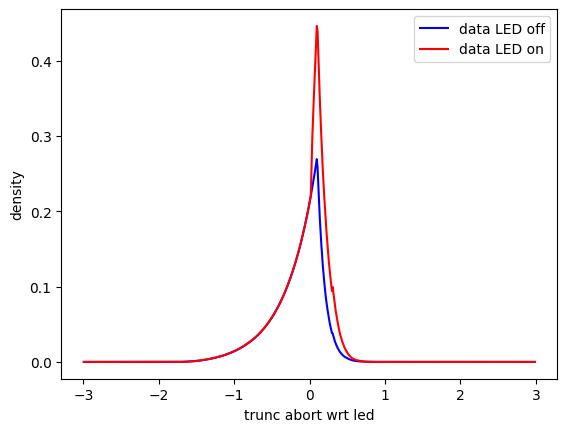

In [20]:
pdf_on_wrt_led_mean = np.mean(pdf_on_wrt_led, axis=0)
pdf_off_wrt_led_mean = np.mean(pdf_off_wrt_led, axis=0)

plt.plot(t_pts_theory_led, pdf_off_wrt_led_mean, label='data LED off', color='b')
plt.plot(t_pts_theory_led, pdf_on_wrt_led_mean, label='data LED on', color='r')
plt.legend()
plt.xlabel('trunc abort wrt led')
plt.ylabel('density');

## data

In [21]:
# df_led_off_trunc_aborts = df_led_off[ (df_led_off['timed_fix'] < df_led_off['intended_fix']) & (df_led_off['timed_fix'] > T_trunc)]
df_led_off_trunc_aborts_wrt_led = df_led_off_trunc_aborts['timed_fix'] - \
                            (df_led_off_trunc_aborts['intended_fix'] - df_led_off_trunc_aborts['LED_onset_time'])

df_led_on_trunc_aborts_wrt_led = df_led_on_trunc_aborts['timed_fix'] - \
                            (df_led_on_trunc_aborts['intended_fix'] - df_led_on_trunc_aborts['LED_onset_time'])


data_off_wrt_led_hist, _ = np.histogram(df_led_off_trunc_aborts_wrt_led, bins=bins_data_led, density=True)
data_off_wrt_led_hist *= len(df_led_off_trunc_aborts) / len(df_led_off)

data_on_wrt_led_hist, _ = np.histogram(df_led_on_trunc_aborts_wrt_led, bins=bins_data_led, density=True)
data_on_wrt_led_hist *= len(df_led_on_trunc_aborts) / len(df_led_on)

## both

(-1.5, 1.0)

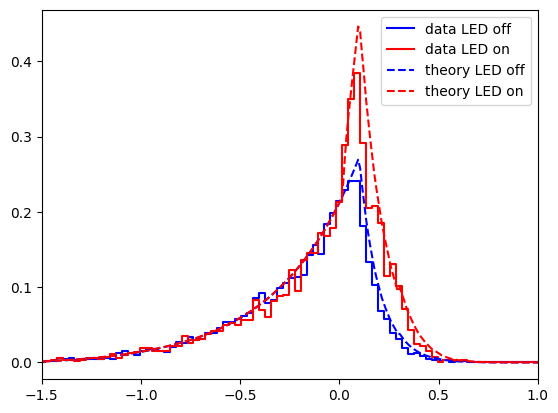

In [22]:
plt.step(t_pts_data_led, data_off_wrt_led_hist, label='data LED off', color='b')
plt.step(t_pts_data_led, data_on_wrt_led_hist, label='data LED on', color='r')

plt.plot(t_pts_theory_led, pdf_off_wrt_led_mean, label='theory LED off', color='b', ls='--')
plt.plot(t_pts_theory_led, pdf_on_wrt_led_mean, label='theory LED on', color='r', ls='--')
plt.legend()
plt.xlim(-1.5, 1)

Text(0.5, 0.98, 'Abort wrt LED onset')

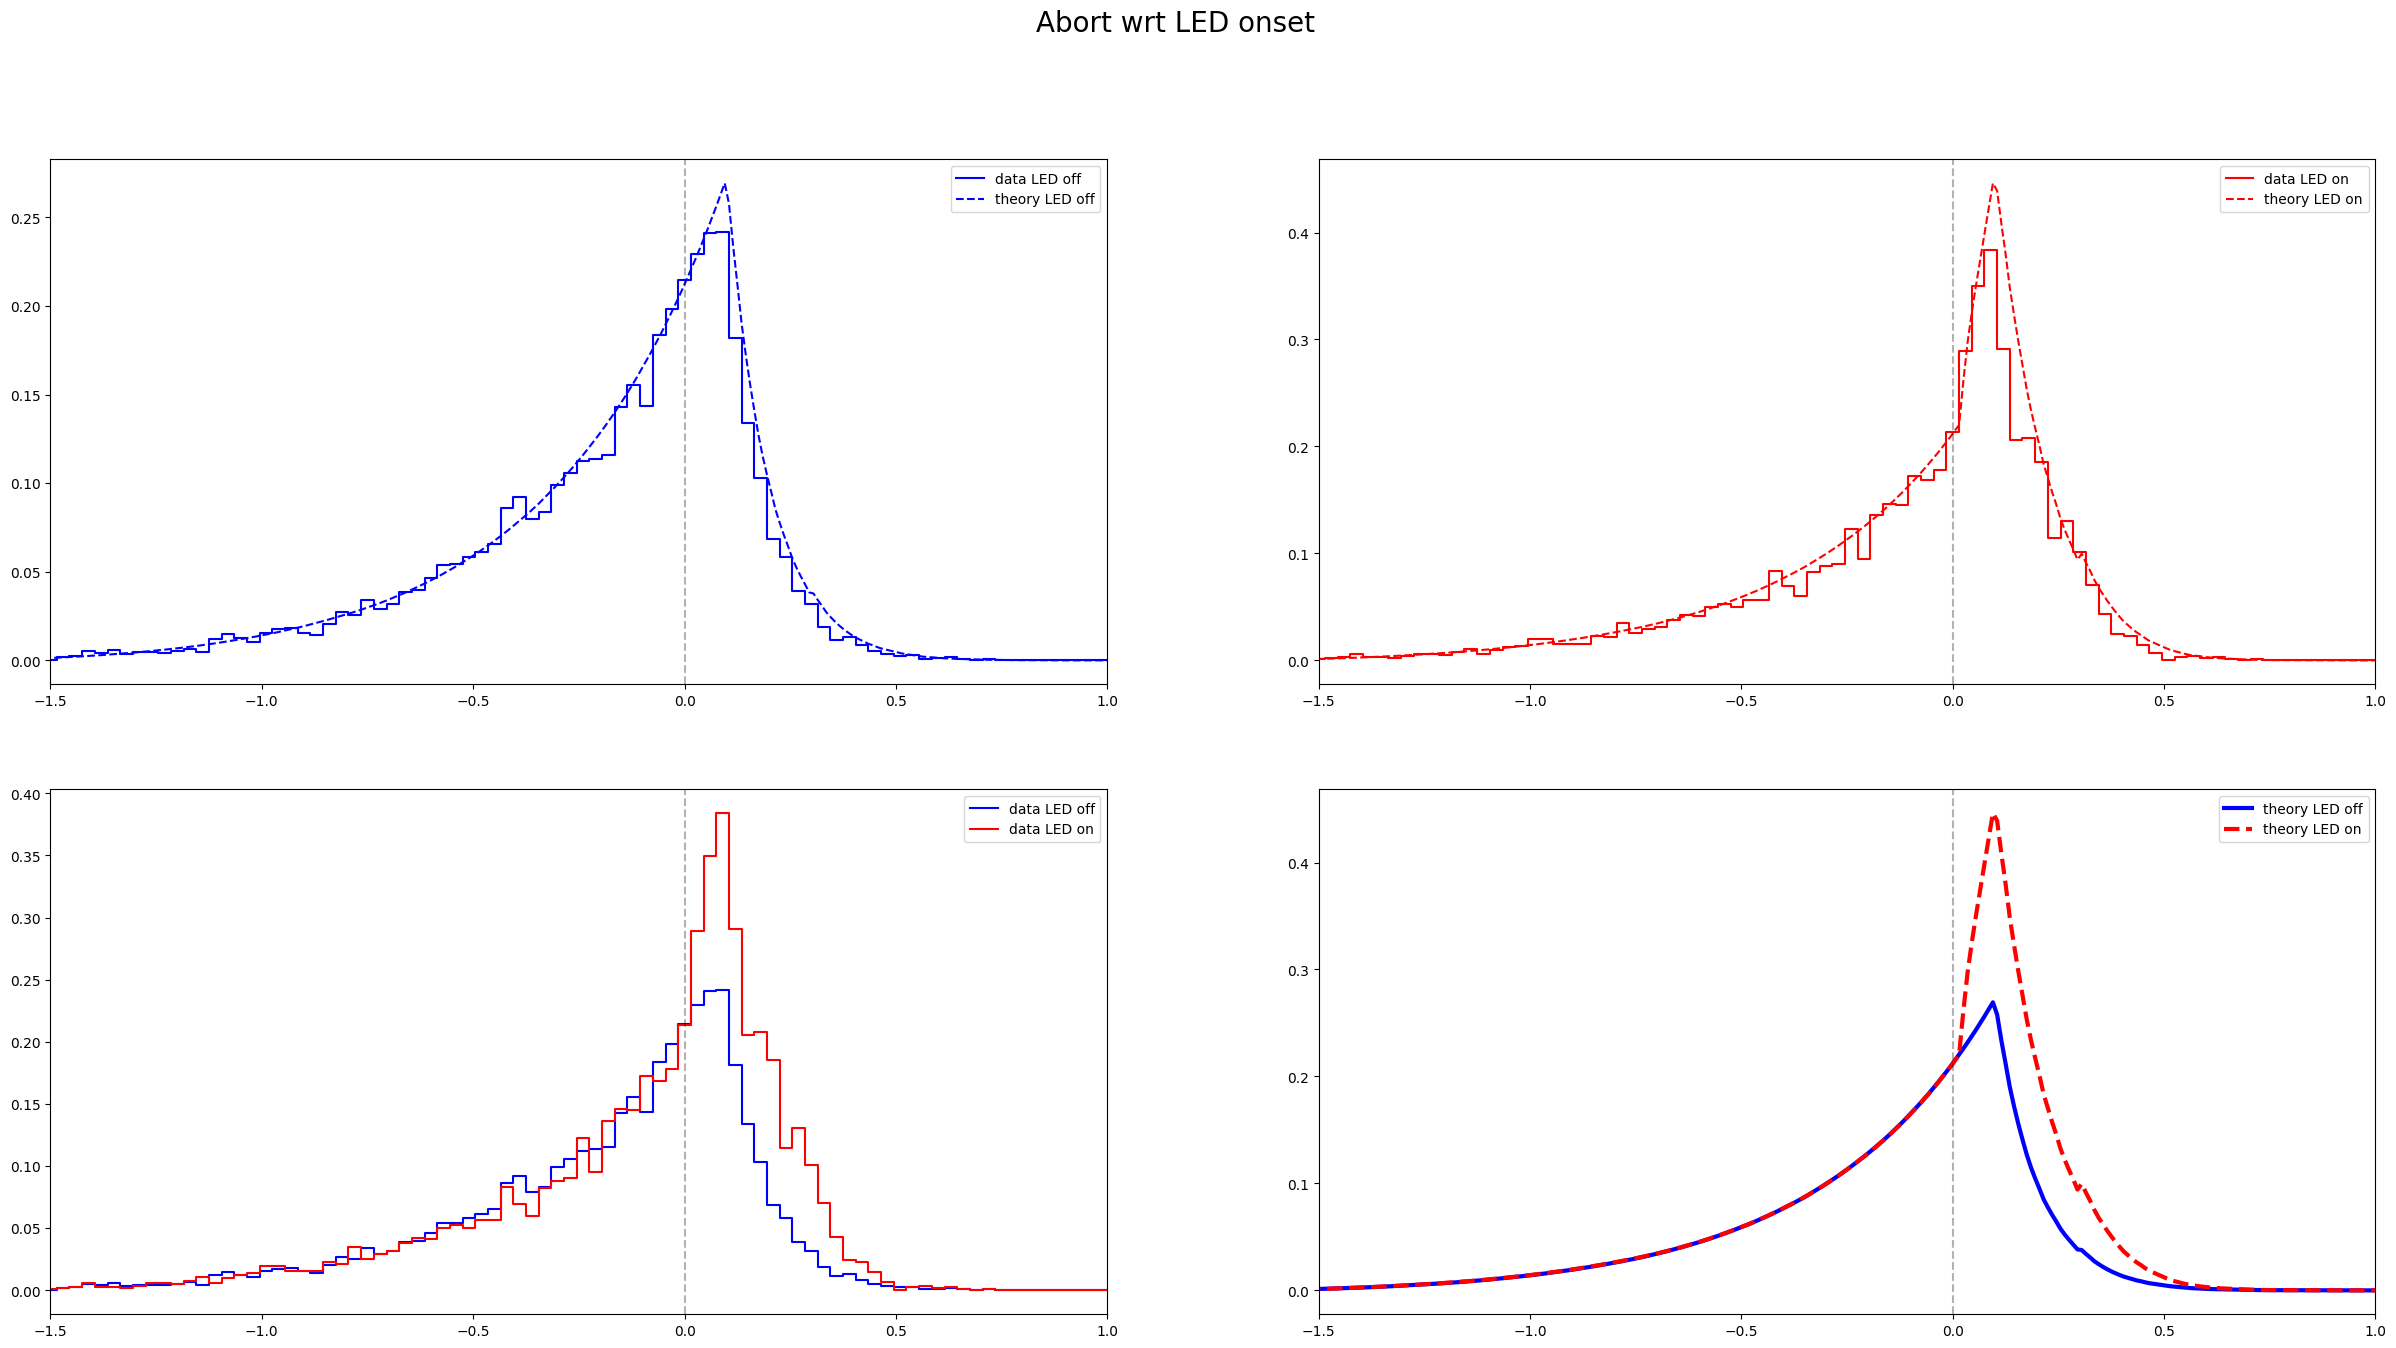

In [26]:
plt.figure(figsize=(30, 15))

plt.subplot(2,2, 1)
plt.step(t_pts_data_led, data_off_wrt_led_hist, label='data LED off', color='b')
plt.plot(t_pts_theory_led, pdf_off_wrt_led_mean, label='theory LED off', color='b', ls='--')
plt.axvline(0, color='k', ls='--', alpha=0.3)
plt.legend()
plt.xlim(-1.5, 1)

plt.subplot(2,2, 2)
plt.step(t_pts_data_led, data_on_wrt_led_hist, label='data LED on', color='r')
plt.plot(t_pts_theory_led, pdf_on_wrt_led_mean, label='theory LED on', color='r', ls='--')
plt.legend()
plt.xlim(-1.5, 1)
plt.axvline(0, color='k', ls='--', alpha=0.3)

plt.subplot(2,2,3)
plt.step(t_pts_data_led, data_off_wrt_led_hist, label='data LED off', color='b')
plt.step(t_pts_data_led, data_on_wrt_led_hist, label='data LED on', color='r')
plt.legend()
plt.xlim(-1.5, 1)
plt.axvline(0, color='k', ls='--', alpha=0.3)


plt.subplot(2,2,4)
plt.plot(t_pts_theory_led, pdf_off_wrt_led_mean, label='theory LED off', color='b', lw=3)
plt.plot(t_pts_theory_led, pdf_on_wrt_led_mean, label='theory LED on', color='r', ls='--', lw=3)
plt.legend()
plt.xlim(-1.5, 1)
plt.axvline(0, color='k', ls='--', alpha=0.3)

plt.suptitle('Abort wrt LED onset', fontsize=20)


# PDF theory - in absence of post LED drift for VP on params

In [67]:
M = 10000

unique_pairs = list(zip(df['intended_fix'], df['intended_fix'] - df['LED_onset_time']))
sampled_pairs = random.sample(unique_pairs, min(M, len(unique_pairs)))

pdf_on_theory_1 = np.zeros((M, len(t_pts_theory)))
pdf_on_theory_only_pre_led = np.zeros((M, len(t_pts_theory)))
pdf_off_theory_1 = np.zeros((M, len(t_pts_theory)))

trunc_factor_only_pre_led = 1 - cum_A_t_fn(T_trunc - t_A_aff_on, base_V_A_on, theta_A_on)
trunc_factor_off = 1 - cum_A_t_fn(T_trunc - t_A_aff_off, V_A_off, theta_A_off)

area_wrt_fix_ON_pre_led = np.zeros((M,))
area_wrt_fix_OFF = np.zeros((M,))

def process_pair_on_off_off(i, t_stim, t_led):
    if t_stim <= t_led:
        print('Issue at index:', i)
        return i, None
    
    trunc_factor = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff_on, base_V_A_on, new_V_A_on, theta_A_on, t_led)
    pdf_on = np.zeros_like(t_pts_theory); pdf_off = np.zeros_like(t_pts_theory); pdf_actual_off = np.zeros_like(t_pts_theory)
    for ti, t in enumerate(t_pts_theory):
        pdf_on[ti] = on_pdf_fn(t, base_V_A_on, new_V_A_on, theta_A_on, t_A_aff_on, t_led, trunc_factor, t_stim)
        pdf_off[ti] = off_pdf_fn(t, t_stim, base_V_A_on, theta_A_on, t_A_aff_on, T_trunc, trunc_factor_only_pre_led)
        pdf_actual_off[ti] = off_pdf_fn(t, t_stim, V_A_off, theta_A_off, t_A_aff_off, T_trunc, trunc_factor_off)

    
    return i, pdf_on, pdf_off, pdf_actual_off, trapz(pdf_off, t_pts_theory), trapz(pdf_actual_off, t_pts_theory)

    # pdf_on = np.array([on_pdf_fn(t, base_V_A_on, new_V_A_on, theta_A_on, t_A_aff_on, t_led, trunc_factor, t_stim) 
    #                     for t in t_pts_theory])
    
    # pdf_off = np.array([off_pdf_fn(t, t_stim, base_V_A_on, theta_A_on, t_A_aff_on, T_trunc, trunc_factor_only_pre_led) for t in t_pts_theory])
    # pdf_actual_off = np.array([off_pdf_fn(t, t_stim, V_A_off, theta_A_off, t_A_aff_off, T_trunc, trunc_factor_off) for t in t_pts_theory])


results_3 = Parallel(n_jobs=30)(delayed(process_pair_on_off_off)(i, t_stim, t_led) for i, (t_stim, t_led) in tqdm(enumerate(sampled_pairs)))

for i, pdf_row_on, pdf_row_off, pdf_off_1,area_pre_led, area_off in results_3:
    pdf_on_theory_1[i,:] = pdf_row_on
    pdf_on_theory_only_pre_led[i,:] = pdf_row_off
    pdf_off_theory_1[i, :] = pdf_off_1
    area_wrt_fix_ON_pre_led[i] = area_pre_led
    area_wrt_fix_OFF[i] = area_off

0it [00:00, ?it/s]

10000it [00:06, 1553.87it/s]


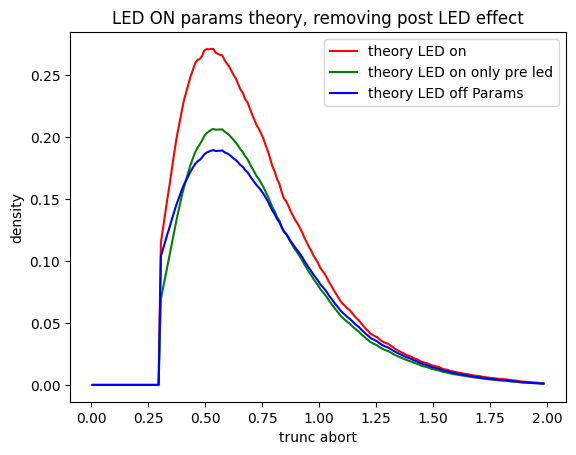

In [68]:
pdf_on_theory_1_mean = np.mean(pdf_on_theory_1, axis=0)
pdf_on_theory_only_pre_led_mean = np.mean(pdf_on_theory_only_pre_led, axis=0)
pdf_off_theory_1_mean = np.mean(pdf_off_theory_1, axis=0)

plt.plot(t_pts_theory, pdf_on_theory_1_mean, label='theory LED on', color='r')
plt.plot(t_pts_theory, pdf_on_theory_only_pre_led_mean, label='theory LED on only pre led', color='g')
plt.plot(t_pts_theory, pdf_off_theory_1_mean, label='theory LED off Params', color='b')

plt.legend()
plt.xlabel('trunc abort')   
plt.ylabel('density')
plt.title('LED ON params theory, removing post LED effect');

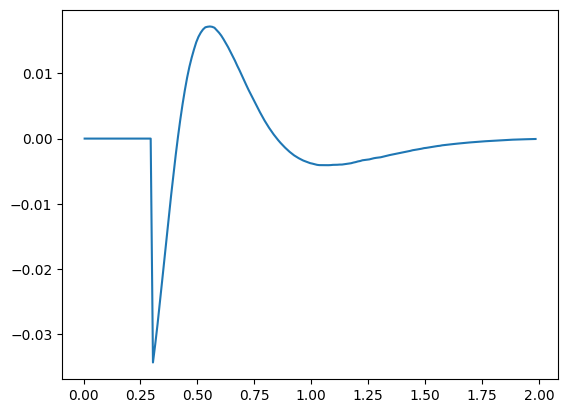

In [69]:
plt.plot(t_pts_theory,pdf_on_theory_only_pre_led_mean -  pdf_off_theory_1_mean)

# PDF theory - in absence of post LED drift for VP on params aligned to LED onset

In [70]:
# M = 10000

# unique_pairs = list(zip(df['intended_fix'], df['intended_fix'] - df['LED_onset_time']))
# sampled_pairs = random.sample(unique_pairs, min(M, len(unique_pairs)))

pdf_on_theory_1_led = np.zeros((M, len(t_pts_theory_led)))
pdf_on_theory_only_pre_led_wrt_led = np.zeros((M, len(t_pts_theory_led)))
pdf_off_theory_1_led = np.zeros((M, len(t_pts_theory_led)))

trunc_factor_only_pre_led = 1 - cum_A_t_fn(T_trunc - t_A_aff_on, base_V_A_on, theta_A_on)
trunc_factor_off = 1 - cum_A_t_fn(T_trunc - t_A_aff_off, V_A_off, theta_A_off)

area_wrt_led_LED_ON_pre_led = np.zeros((M,))
area_wrt_led_LED_OFF = np.zeros((M,))

def process_pair_on_off_off_wrt_led(i, t_stim, t_led):
    if t_stim <= t_led:
        print('Issue at index:', i)
        return i, None
    
    trunc_factor = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff_on, base_V_A_on, new_V_A_on, theta_A_on, t_led)
    pdf_on = np.zeros_like(t_pts_theory_led)
    pdf_off = np.zeros_like(t_pts_theory_led)
    pdf_actual_off = np.zeros_like(t_pts_theory_led)

    for ti, t in enumerate(t_pts_theory_led):
        pdf_on[ti] = on_pdf_fn(t + t_led, base_V_A_on, new_V_A_on, theta_A_on, t_A_aff_on, t_led, trunc_factor, t_stim)
        pdf_off[ti] = off_pdf_fn(t + t_led, t_stim, base_V_A_on, theta_A_on, t_A_aff_on, T_trunc, trunc_factor_only_pre_led)
        pdf_actual_off[ti] = off_pdf_fn(t + t_led, t_stim, V_A_off, theta_A_off, t_A_aff_off, T_trunc, trunc_factor_off)
    
    
    return i, pdf_on, pdf_off, pdf_actual_off, trapz(pdf_off, t_pts_theory_led), trapz(pdf_actual_off, t_pts_theory_led)

results_3_led = Parallel(n_jobs=30)(delayed(process_pair_on_off_off_wrt_led)(i, t_stim, t_led) for i, (t_stim, t_led) in tqdm(enumerate(sampled_pairs)))

for i, pdf_row_on, pdf_row_off, pdf_off_1, area_pre_led, area_off in results_3_led:
    pdf_on_theory_1_led[i,:] = pdf_row_on
    pdf_on_theory_only_pre_led_wrt_led[i,:] = pdf_row_off
    pdf_off_theory_1_led[i, :] = pdf_off_1
    area_wrt_led_LED_ON_pre_led[i] = area_pre_led
    area_wrt_led_LED_OFF[i] = area_off

10000it [00:05, 1702.64it/s]


Text(0, 0.5, 'density')

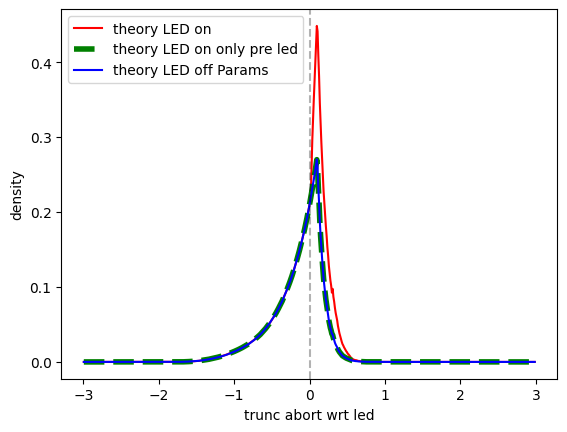

In [71]:
pdf_on_theory_1_led_mean = np.mean(pdf_on_theory_1_led, axis=0)
pdf_on_theory_only_pre_led_wrt_led_mean = np.mean(pdf_on_theory_only_pre_led_wrt_led, axis=0)
pdf_off_theory_1_led_mean = np.mean(pdf_off_theory_1_led, axis=0)

plt.plot(t_pts_theory_led, pdf_on_theory_1_led_mean, label='theory LED on', color='r')
plt.plot(t_pts_theory_led, pdf_on_theory_only_pre_led_wrt_led_mean, label='theory LED on only pre led', color='g', lw=4, ls='--')
plt.plot(t_pts_theory_led, pdf_off_theory_1_led_mean, label='theory LED off Params', color='b')
plt.axvline(0, color='k', ls='--', alpha=0.3)
plt.legend()
plt.xlabel('trunc abort wrt led')
plt.ylabel('density')

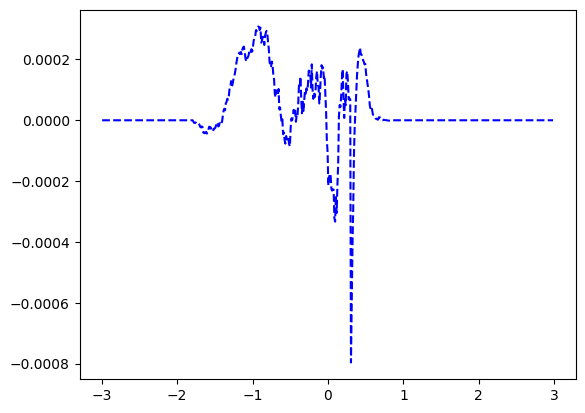

In [72]:
plt.plot(t_pts_theory_led, pdf_on_theory_only_pre_led_wrt_led_mean - pdf_off_theory_1_led_mean, label='diff', color='b', ls='--')

# see areas wrt fix and LED

(0.0, 0.2)

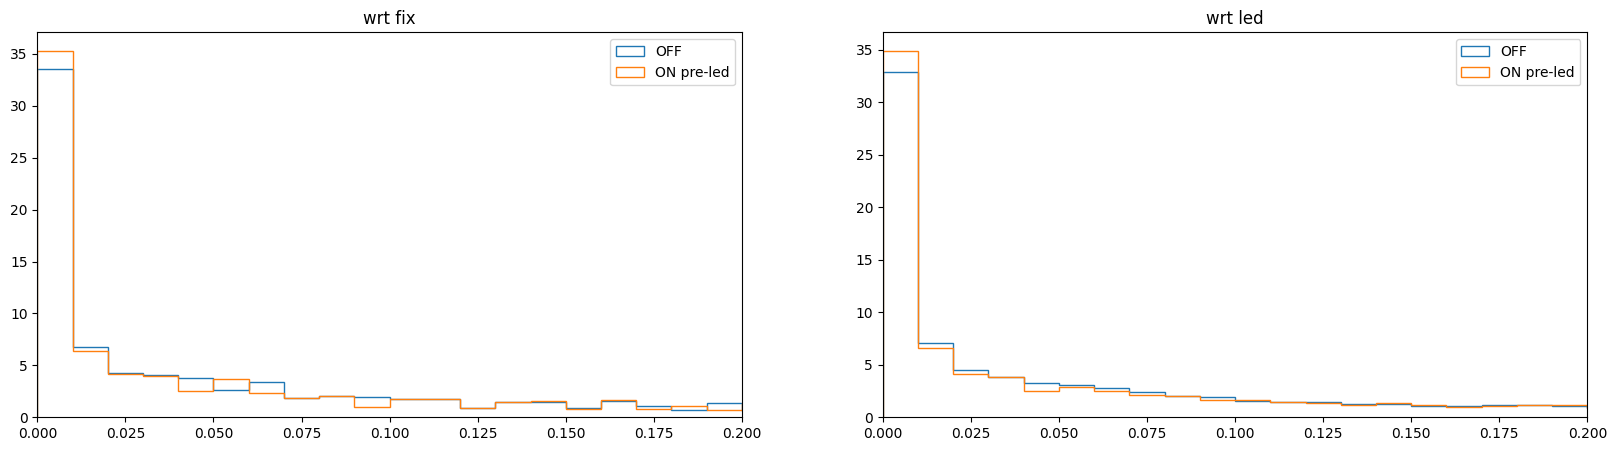

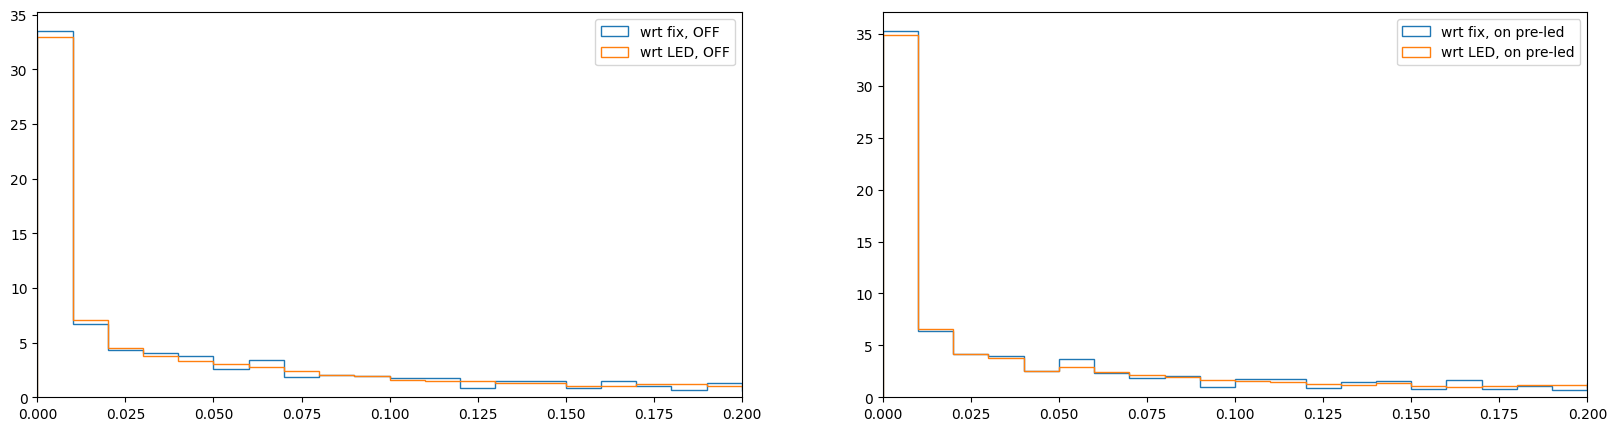

In [66]:
bins_area = np.arange(0, 1, 0.01)
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.hist(area_wrt_fix_OFF, label='OFF', density=True, histtype='step', bins=bins_area);
plt.hist(area_wrt_fix_ON_pre_led, label='ON pre-led', density=True, histtype='step', bins=bins_area);
plt.title('wrt fix')
plt.legend();
plt.xlim(0,0.2)

plt.subplot(1,2,2)
plt.hist(area_wrt_led_LED_OFF, label='OFF', density=True, histtype='step', bins=bins_area);
plt.hist(area_wrt_led_LED_ON_pre_led, label='ON pre-led', density=True, histtype='step', bins=bins_area);
plt.title('wrt led')
plt.legend();
plt.xlim(0,0.2)


plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.hist(area_wrt_fix_OFF, label='wrt fix, OFF', density=True, histtype='step', bins=bins_area);
plt.hist(area_wrt_led_LED_OFF, label='wrt LED, OFF', density=True, histtype='step', bins=bins_area);
plt.legend();
plt.xlim(0,0.2)

plt.subplot(1,2,2)
plt.hist(area_wrt_fix_ON_pre_led, label='wrt fix, on pre-led', density=True, histtype='step', bins=bins_area);
plt.hist(area_wrt_led_LED_ON_pre_led, label='wrt LED, on pre-led', density=True, histtype='step', bins=bins_area);
plt.legend();
plt.xlim(0,0.2)
